In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset

In [ ]:
data = pd.read_csv("/content/sample_data/Combined Data.csv")

data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)

data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data = data.sample(n=40000,).reset_index(drop=True)
data

,statement,status
0,"""Whoever sells with two sales in one transacti...",Normal
1,"I have had a decent summer, nothing crazy like...",Depression
2,I was also forced (with threat of prison time)...,Stress
3,guy i need help i m feel bad in my skin for to...,Depression
4,there are guards you have to ask for everythig...,Stress
...,...,...
39995,"* Holy shit. My Friends mom called me, she sai...",Suicidal
39996,so fucking bored of work,Normal
39997,Maybe it will be a huge paragraph but please r...,Suicidal
39998,@KellyNg With mainstream media's reporting &am...,Normal


In [ ]:
import re
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')


stop_words = set(stopwords.words('english'))

def clean_statement(statement):

    statement = statement.lower()

    statement = re.sub(r'[^\w\s]', '', statement)

    statement = re.sub(r'\d+', '', statement)

    words = statement.split()


    words = [word for word in words if word not in stop_words]

    cleaned_statement = ' '.join(words)

    return cleaned_statement

data['statement'] = data['statement'].apply(clean_statement)

data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,statement,status
0,whoever sells two sales one transaction lowest...,Normal
1,decent summer nothing crazy like kids bad stuf...,Depression
2,also forced threat prison time get asleep apne...,Stress
3,guy need help feel bad skin long trying feel b...,Depression
4,guards ask everythig people live ok either loo...,Stress
...,...,...
39995,holy shit friends mom called said daughter com...,Suicidal
39996,fucking bored work,Normal
39997,maybe huge paragraph please read trying best e...,Suicidal
39998,kellyng mainstream medias reporting amp increa...,Normal


In [ ]:
data['status'].value_counts()

,count
status,
Normal,12486
Depression,11619
Suicidal,8085
Anxiety,2920
Bipolar,2099
Stress,1959
Personality disorder,832


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

X = data.drop(columns=['status'])
y = data['status']

X_resampled, y_resampled = ros.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

print(data['status'].value_counts())

status
Normal                  12486
Depression              12486
Stress                  12486
Suicidal                12486
Bipolar                 12486
Anxiety                 12486
Personality disorder    12486
Name: count, dtype: int64


In [ ]:

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size=0.2)

In [ ]:
max([len(text) for text in data['statement']])

25289

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})

In [ ]:
BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hungundsana (hungundsana-abc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.311500,0.318163
2,0.197300,0.229231


Epoch,Training Loss,Validation Loss
1,0.311500,0.318163
2,0.197300,0.229231
3,0.152400,0.223480
4,0.076600,0.273337


TrainOutput(global_step=10925, training_loss=0.23884690089138477, metrics={'train_runtime': 12484.8464, 'train_samples_per_second': 28.002, 'train_steps_per_second': 0.875, 'total_flos': 3.591997153812e+16, 'train_loss': 0.23884690089138477, 'epoch': 4.997940974605354})

                      precision    recall  f1-score   support

             Anxiety       0.96      0.98      0.97       532
             Bipolar       0.97      0.99      0.98       559
          Depression       0.87      0.59      0.70       557
              Normal       0.93      0.92      0.92       610
Personality disorder       0.99      1.00      1.00       581
              Stress       0.96      1.00      0.98       570
            Suicidal       0.73      0.90      0.81       598

            accuracy                           0.91      4007
           macro avg       0.92      0.91      0.91      4007
        weighted avg       0.91      0.91      0.91      4007



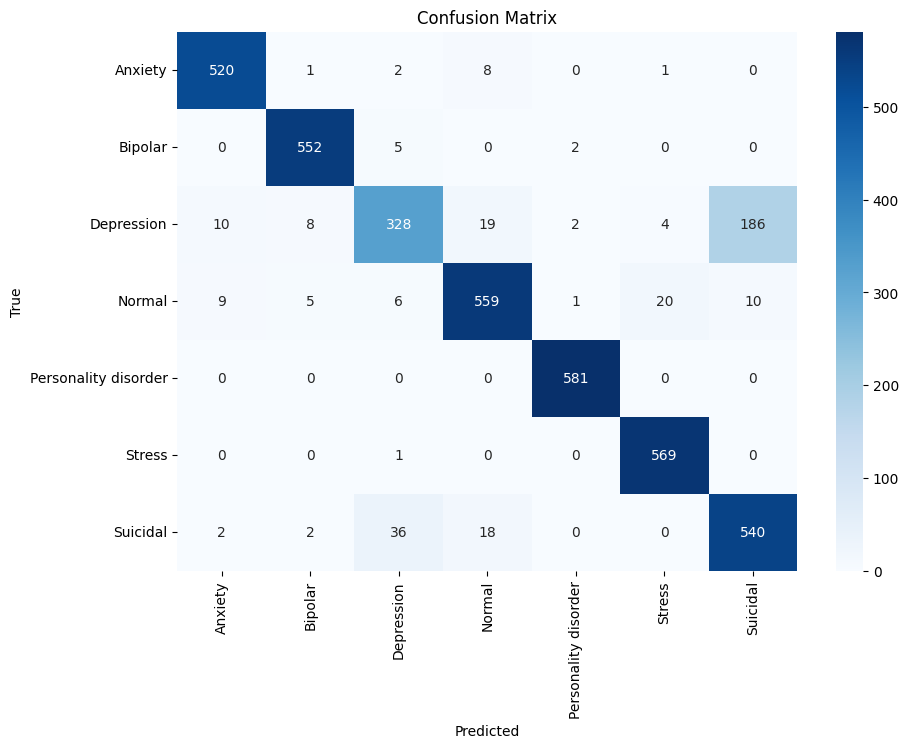

In [ ]:

predictions, labels, _ = trainer.predict(test_dataset)


predicted_labels = np.argmax(predictions, axis=1)


print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))


cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
accuracy

0.9106563513850762

In [ ]:

trainer.save_model("saved_mental_status_bert")
tokenizer.save_pretrained("saved_mental_status_bert")


import pickle

pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_mental_status_bert")

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

In [ ]:
def detect_text(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

sample_texts = [
    "I want to die",
    "I am Happy today",
    "I had a bad day today",
    "I'm scared for my results"
]

for text in sample_texts:
    predicted_class = detect_text(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

Sentence: I want to die
Predicted class: Suicidal



In [ ]:
import shutil
from google.colab import files


model_save_path = "saved_mental_status_bert"
tokenizer_save_path = "saved_mental_status_bert"


trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)


zip_file_path = "saved_mental_status_bert"

shutil.make_archive(zip_file_path, 'zip', root_dir='saved_mental_status_bert', base_dir='')

files.download(f"{zip_file_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00
